In [2]:
from minisom import MiniSom    
from sklearn.cluster import KMeans
import numpy as np
data = [[ 0.80,  0.55,  0.22,  0.03],
        [ 0.82,  0.50,  0.23,  0.03],
        [ 0.80,  0.54,  0.22,  0.03],
        [ 0.80,  0.53,  0.26,  0.03],
        [ 0.79,  0.56,  0.22,  0.03],
        [ 0.75,  0.60,  0.25,  0.03],
        [ 0.77,  0.59,  0.22,  0.03]]

data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
# data normalization
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)

# Initialization and training
d1 = 10
d2 = 10
som = MiniSom(d1, d2, 4, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)

som.pca_weights_init(data)
print("Training...")
som.train_batch(data, 1000, verbose=True)  # random training



#som = MiniSom(3, 3, 4, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
#som.train_random(data, 100) # trains the SOM with 100 iterations
print(som.get_weights())
print('------')
rweights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
kmeans = KMeans(n_clusters=3, random_state=0).fit(rweights)
labels = kmeans.labels_
print("Labels",labels)

Training...


 [  963 / 1000 ]  96% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.749549895583775e-05
 topographic error: 0.14666666666666667
[[[0.69777471 0.29890575 0.6152407  0.20994989]
  [0.69305668 0.30771759 0.60826549 0.23415099]
  [0.69076088 0.32268326 0.60322519 0.23365761]
  [0.67380451 0.3371668  0.60258975 0.26151847]
  [0.6746875  0.3612103  0.59246737 0.25084688]
  [0.69161661 0.34835641 0.58617876 0.23700555]
  [0.7006295  0.34646803 0.58063208 0.22664228]
  [0.71241991 0.35003134 0.57213072 0.20589821]
  [0.71756553 0.3459022  0.57697324 0.17967256]
  [0.72352406 0.34684949 0.57449298 0.16138138]]

 [[0.71137996 0.26300873 0.62180148 0.19366168]
  [0.70385976 0.29681038 0.60575329 0.21918566]
  [0.70199525 0.32216587 0.58735741 0.24062767]
  [0.68789874 0.33745002 0.59176894 0.24951894]
  [0.68311416 0.34468191 0.60051898 0.23041529]
  [0.69368654 0.34474433 0.59704255 0.20799164]
  [0.69890242 0.3574622  0.58306036 0.20756636]
  [0.71180003 0.35627646 0.56796894 0.20868792]
  [0.72674971

In [3]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
%load_ext autoreload

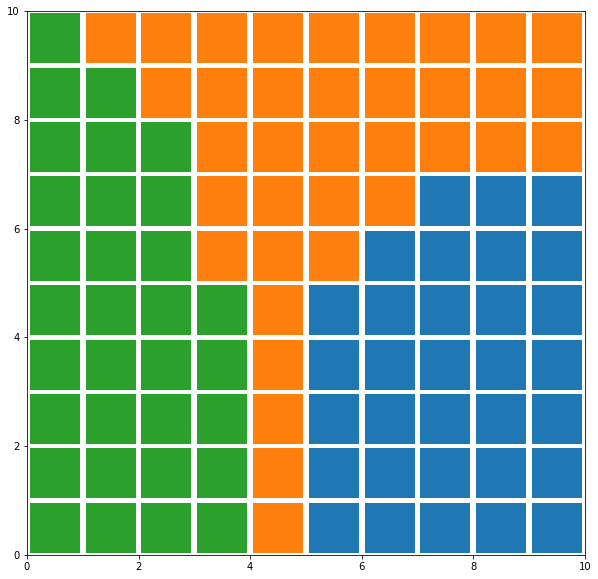

In [4]:

plt.figure(figsize=(d1, d2))
# Plotting the response for each pattern in the iris dataset
win_map = som.win_map(rweights)
#plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
#plt.colorbar()
# use different colors and markers for each label
#markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for cnt, xx in enumerate(rweights):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[labels[cnt]],
             markeredgecolor=colors[labels[cnt]], markersize=48, markeredgewidth=2)
plt.axis([0, d1, 0, d2])
plt.show()
